# Advanced Lane Finding

## Import libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

import cv2
import glob
import os

from moviepy.editor import VideoFileClip

In [33]:
#out_dir = 'output_images/'
out_dir = 'out_2_imgs/'

# Utility method to save images
def save_img(img, name):
    #rbg_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    cv2.imwrite(out_dir+name, img)


## Load Camera Calibration Images

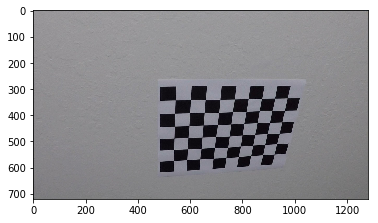

In [3]:
cal_images = glob.glob('camera_cal/calibration*.jpg')

# Print an example
example_img = mpimg.imread(cal_images[16])
plt.imshow(example_img)

In [4]:
# Object points - points in 3D world
obj_points = []

# Image points - points in 2D world on flat surface
img_points = []

# Prepare object points (9x6 chessboard)
# (x, y, z)
# (0, 0, 0), (1, 0, 0) ... (8, 5, 0)

# Create array of 9x6 points with 3 points x,y,z each
objp = np.zeros((9*6, 3), np.float32)

# Assign proper points values to objp
# Z coordinate will remain zero always
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)


camera_cal/calibration3.jpg
Total images with corners: 17
17
17


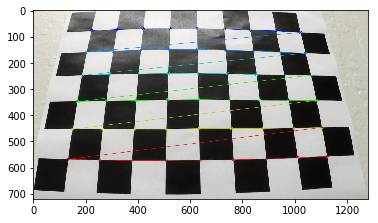

In [5]:
# Calculating Image points from image using openCV

count = 0
for img_path in cal_images:
    # Read each image
    img = mpimg.imread(img_path)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9, 6), None)

    # Are corners found?
    if ret == True:
        
        # Add image and object points for each image found having corners
        obj_points.append(objp)
        img_points.append(corners)
        
        # Draw image, corners for one image
        if count == 2:
            corner_img = cv2.drawChessboardCorners(img, (9, 6), corners, ret)
            print(img_path)
            plt.figure()
            plt.imshow(img)
            cv2.imwrite(out_dir+'draw_corners.jpg', img)
        
        # Increase count only for images with corners found
        count = count + 1

print('Total images with corners: {}'.format(count))
print(len(obj_points))
print(len(img_points))

## Calibrate Camera using Image and Object points

In [6]:
# Calibrate camera
# mtx = Camera matrix
# dist = Distortion Coefficients

ret, mtx, dist, rvects, tvects = cv2.calibrateCamera(obj_points, img_points, example_img.shape[1::-1], None, None)

## Undistort an image

True

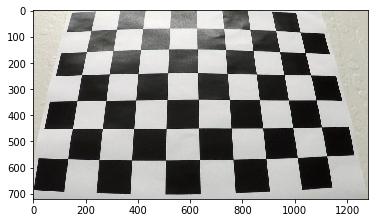

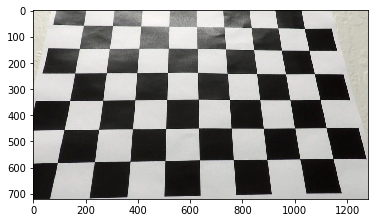

In [7]:
# Undistort image fucntion
def undistort_img(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

# Undistort example image
example_img = mpimg.imread(cal_images[4])
plt.figure()
plt.imshow(example_img)
cv2.imwrite(out_dir+'distorted_img.jpg', example_img)

undist_img = undistort_img(example_img, mtx, dist)
plt.figure()
plt.imshow(undist_img)
cv2.imwrite(out_dir+'un_distorted_img.jpg', undist_img)

## Undistort Test Images

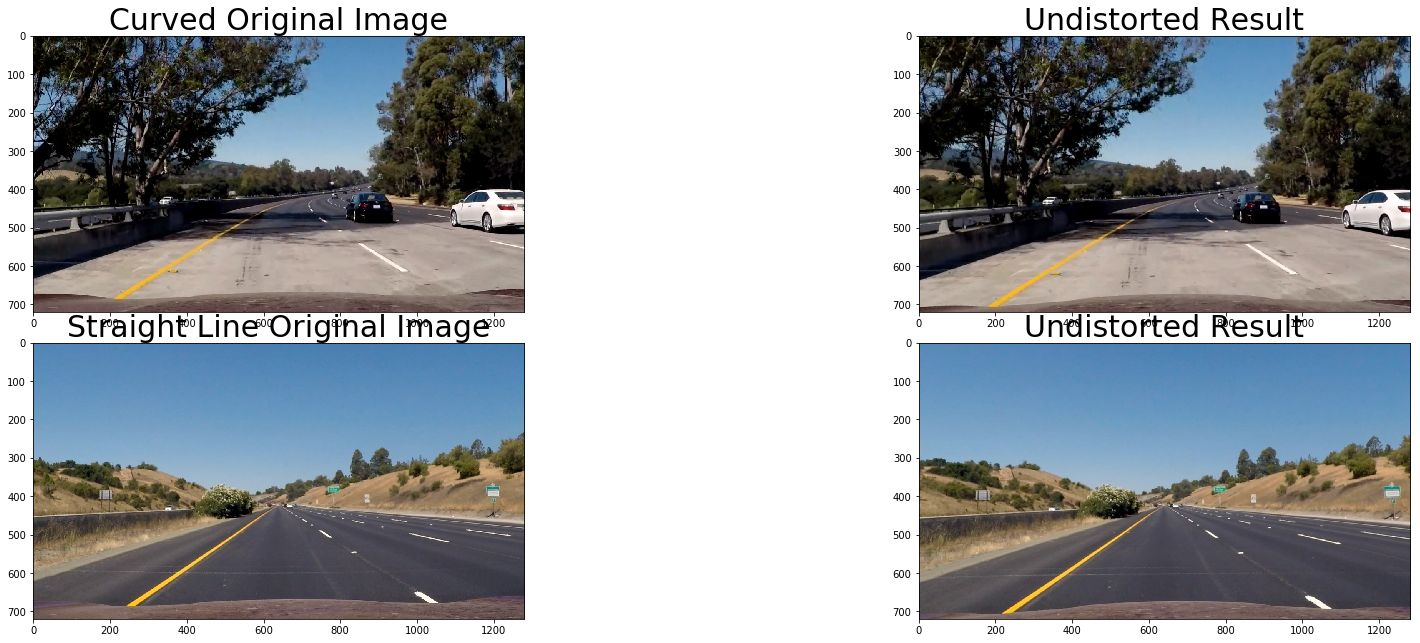

In [262]:
# Read all test images
test_img_dir = 'test_images/'
images = os.listdir(test_img_dir)
test_images = []

# Append image directory to all files
for img in images:
    test_images.append(test_img_dir + img)

curved_img = mpimg.imread(test_images[1])
straight_line_img = mpimg.imread(test_images[7])

f, axes = plt.subplots(2, 2, figsize=(24, 9))
f.tight_layout()

axes[0,0].imshow(curved_img)
axes[0,0].set_title('Curved Original Image', fontsize=30)

undistort_curved_result = undistort_img(curved_img, mtx, dist)

axes[0,1].imshow(undistort_curved_result)
axes[0,1].set_title('Undistorted Result', fontsize=30)

axes[1,0].imshow(straight_line_img)
axes[1,0].set_title('Straight Line Original Image', fontsize=30)

undistort_straight_result = undistort_img(straight_line_img, mtx, dist)

axes[1,1].imshow(undistort_straight_result)
axes[1,1].set_title('Undistorted Result', fontsize=30)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [984]:
# Change this flag to true if want to save images
DBG = False

## Compute Color and Gradient Threshold

In [968]:

# Calculate Sobel threshold
def sobel_threshold(img, sobel_thresh=(0, 255), orientation='x', kernel_size=3):
    # Convert to Grayscale color space
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate gradient in 'orientation' direction
    if orientation == 'x':
        sobel_val = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel_size)
    else:
        sobel_val = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel_size)
        
    # Calculate absolute value
    abs_sobel = np.absolute(sobel_val)
    
    #Scale the soebl values to 8-bit image
    scaled_sobel = np.uint8( (255*abs_sobel) / np.max(abs_sobel) )
    
    # Create a binary image based on sobel
    sobel_binary = np.zeros_like(scaled_sobel)
    
    sobel_binary[(scaled_sobel >= sobel_thresh[0]) & (scaled_sobel < sobel_thresh[1])] = 1
    
    return sobel_binary



#Calculate color threshold
def color_threshold(img, s_color_thresh=(0, 255), v_color_thresh=(0, 255)):
    # Convert to HLS color space
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls_img[:,:,2]
    l_channel = hls_img[:,:,1]
    
    # Convert to HSV color space
    hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hls_img[:,:,2]

    
    # Get the R-Channel
    r_channel = img[:,:,0]
    r_color_binary = np.zeros_like(r_channel)
    #r_color_binary[(r_channel >= 100) & (r_channel <= 120)] = 1
    r_color_binary[(r_channel >= 190) & (r_channel <= 255)] = 1
    
    
    
    # Get the G-Channel
    g_channel = img[:,:,1]
    g_color_binary = np.zeros_like(g_channel)
    #g_color_binary[(g_channel >= 110) & (g_channel <= 120)] = 1
    g_color_binary[(g_channel >= 190) & (g_channel <= 255)] = 1
    
    
    yellow_color_binary = np.zeros_like(r_channel)
    yellow_color_binary[(r_color_binary == 1) | (g_color_binary == 1)] = 1
    
    white_color_binary = np.zeros_like(r_channel)
    white_color_binary[(r_channel >= 200) & (r_channel <= 255) | ((g_channel >= 200) & (g_channel <= 255))] = 1
    
    
    # Create an array like S-channel
    s_color_binary = np.zeros_like(s_channel)
    
    # Set pixel points to 1 where S-channel is between thresholds
    s_color_binary[(s_channel >= s_color_thresh[0]) & (s_channel <= s_color_thresh[1])] = 1
    

    
    # Create an array like L-channel
    l_color_binary = np.zeros_like(l_channel)
    
    # Set pixel points to 1 where L-channel is between thresholds
    l_color_binary[(l_channel >= 190) & (l_channel <= 245)] = 1
    
    
    combined_color_binary = np.zeros_like(s_channel)
    #combined_color_binary[(s_color_binary == 1)] = 1
    
    combined_color_binary[((s_color_binary == 1)| (l_color_binary == 1)) | ((yellow_color_binary == 1) | (white_color_binary == 1))] = 1
    
    
    if DBG == True:
        out_img_R_color = np.zeros_like(img[:,:,0])
        out_img_R_color[(r_color_binary == 1)] = 255
        save_img(out_img_R_color, '1_1_out_img_R_color.jpg')
    
        out_img_G_color = np.zeros_like(img[:,:,0])
        out_img_G_color[(g_color_binary == 1)] = 255
        save_img(out_img_G_color, '1_2_out_img_G_color.jpg')
        
        out_img_Yello_color = np.zeros_like(img[:,:,0])
        out_img_Yello_color[(yellow_color_binary == 1)] = 255
        save_img(out_img_Yello_color, '1_4_out_img_Yello_color.jpg')
        
        out_img_White_color = np.zeros_like(img[:,:,0])
        out_img_White_color[(white_color_binary == 1)] = 255
        save_img(out_img_White_color, '1_5_out_img_White_color.jpg')
    
    
        out_img_s_color = np.zeros_like(img[:,:,0])
        out_img_s_color[(s_color_binary == 1)] = 255
        save_img(out_img_s_color, '1_3_out_img_s_color.jpg')

        #out_img_v_color = np.zeros_like(img[:,:,0])
        #out_img_v_color[(v_color_binary == 1)] = 255
        #save_img(out_img_v_color, '2_out_img_v_color.jpg')

        out_img_L_color = np.zeros_like(img[:,:,0])
        out_img_L_color[(l_color_binary == 1)] = 255
        save_img(out_img_L_color, '2_1_out_img_L_color.jpg')
        
        out_img_combined_color = np.zeros_like(img[:,:,0])
        out_img_combined_color[(combined_color_binary == 1)] = 255
        save_img(out_img_combined_color, '3_out_img_combined_color.jpg')
    
    
    return combined_color_binary



def combined_binary(img):
    
    out_img = np.zeros_like(img[:,:,0])
    
    sobel_x = sobel_threshold(img, sobel_thresh=(15, 255), orientation='x')
    sobel_y = sobel_threshold(img, sobel_thresh=(24, 255), orientation='y')
    
    #sobel_x = sobel_threshold(img, sobel_thresh=(12, 255), orientation='x')
    #sobel_y = sobel_threshold(img, sobel_thresh=(20, 255), orientation='y')
    
    #color_thresh = color_threshold(img, s_color_thresh=(95, 150), v_color_thresh=(50, 150))
    color_thresh = color_threshold(img, s_color_thresh=(115, 138), v_color_thresh=(30, 60))
    
    
    if DBG == True:
        out_img_x = np.zeros_like(img[:,:,0])
        out_img_x[(sobel_x == 1)] = 255
        save_img(out_img_x, '4_1_sobel_x.jpg')

        out_img_y = np.zeros_like(img[:,:,0])
        out_img_y[(sobel_y == 1)] = 255
        save_img(out_img_y, '4_2_sobel_y.jpg')


        out_img_xy = np.zeros_like(img[:,:,0])
        out_img_xy[(sobel_x == 1) & (sobel_y == 1)] = 255
        save_img(out_img_xy, '4_3_sobel_xy.jpg')

        out_img_color = np.zeros_like(img[:,:,0])
        out_img_color[(color_thresh == 1)] = 255
        save_img(out_img_color, '5_color_thresh.jpg')
    
    out_img[( (sobel_x == 1) & (sobel_y == 1) | (color_thresh == 1) )] = 255
    #out_img[( (sobel_x == 1) | (color_thresh == 1) )] = 255
    
    return out_img

## Perspective transform

In [969]:
# Store the src points for straight line image

def warp_image(img):
    
    # (size) = (    x       ,     y       )
    img_size = (img.shape[1], img.shape[0])
    
    # Calculate source and destination points    
    #lower_left_pt = [200., 720.]
    #upper_left_pt = [453., 547.]
    #upper_right_pt = [835., 547.]
    #lower_right_pt = [1100., 720.]
    
    lower_left_pt = [200., 720.]
    upper_left_pt = [570., 470.]
    upper_right_pt = [720., 470.]
    lower_right_pt = [1130., 720.]
    
    src = np.float32([lower_left_pt, upper_left_pt, upper_right_pt, lower_right_pt])
    
    
    #dst = np.float32([
    #    [320., 720.],
    #    [320., 590.4],
    #    [960, 590.4],
    #    [960, 720.]
    #])
    
    #dst = np.float32([
    #    [320., 720.],
    #    [320., 0],
    #    [980, 0],
    #    [980, 720.]
    #])
    
    dst = np.float32([
        [350., 720.],
        [350., 0],
        [980, 0],
        [980, 720.]
    ])
    
    
    # Get the perspective transformation matrix
    M = cv2.getPerspectiveTransform(src, dst)
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    #Warp the image
    warped_img = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    return warped_img, Minv

## Find lane lines using convolution

In [970]:
class LaneLineFinder():
    def __init__(self, win_width, win_height, margin, no_of_fits):
        self.window_width = win_width
        
        self.window_height = win_height
        
        self.window_margin = margin
        
        self.recent_window_centroids = []
        
        self.no_of_fits = no_of_fits
    
    
    # Find the window centroids in image
    def find_window_centroids(self, warped_img):
        
        # Store the (left,right) window centroid positions per level
        window_centroids = []
        
        # Create our window template that we will use for convolutions
        window = np.ones(self.window_width)

        # Now find the starting position of left and right lane markers by first summing
        # the vertical slice of image (Use 10% of bottom of image)
        
        #y_upper_limit = int(3*warped_img.shape[0]/4)
        y_upper_limit = int(0.75*warped_img.shape[0])
        
        # Find left and right cut off points (Use 45% of left and 45% of right)
        # Use this for first window
        x_left_min = int(warped_img.shape[1]*0.1)
        x_left_max = int(warped_img.shape[1]*0.45)
        
        x_right_min = int(warped_img.shape[1]*0.6)
        x_right_max = int(warped_img.shape[1]*0.9)
        
        # For next consecutive windows use mid point
        x_mid = int(warped_img.shape[1]/2)

        if DBG == True:
            print("Limits")
            print("X Left: ({}, {})".format(x_left_min, x_left_max))
            print("X Right: ({}, {})".format(x_right_min, x_right_max))
            print("X Mid: {}, y upper: {}".format(x_mid, y_upper_limit))
        
        
        #left_slice = np.sum(warped_img[y_upper_limit:, x_left_min:x_left_max], axis=0)
        left_slice = np.sum(warped_img[y_upper_limit:, x_left_min:x_mid], axis=0)
        left_center = (np.argmax(np.convolve(window, left_slice)) - (self.window_width/2) + x_left_min)
        
        right_slice = (np.sum(warped_img[y_upper_limit:, x_right_min:x_right_max], axis=0))
        #right_slice = (np.sum(warped_img[y_upper_limit:, x_mid:x_right_max], axis=0))
        right_center = (np.argmax(np.convolve(window, right_slice)) - (self.window_width/2) + x_right_min)
        #right_center = (np.argmax(np.convolve(window, right_slice)) - (self.window_width/2) + x_mid)
        
        #Append the first bottom window centroids
        window_centroids.append((left_center, right_center))
        
        if DBG == True:
            print("Center: {}, {}".format(left_center, right_center))

        #Total levels in image
        levels = int(warped_img.shape[0]/self.window_height)
        
        #Loop over all windows to find window centroids:
        for level in range(1, levels):
            
            if DBG == True:
                print()
                print("Level: {}".format(level))

            #Get the window slice for level
            y_upper_limit = (warped_img.shape[0] - ((level + 1) * self.window_height))
            y_lower_limit = (warped_img.shape[0] - (level * self.window_height))
            
            image_layer = np.sum(warped_img[y_upper_limit:y_lower_limit,:], axis=0)
            conv_signal = np.convolve(window, image_layer)
            
            
            offset = (self.window_width/2)
            
            #Use (left, right) found earlier to look up around that area for next best window centroid
            left_min = int(max(left_center + offset - self.window_margin, 0))
            left_max = int(min(left_center + offset + self.window_margin, warped_img.shape[1]))
            
            left_argmax = np.argmax(conv_signal[left_min:left_max])
            
            if left_argmax != 0:
                if DBG == True:
                    print("Left argmax is : {}".format(left_argmax))
                left_center = (left_argmax + left_min - offset)
            else:
                if DBG == True:
                    print('No values in left center')
            
            right_min = int(max(right_center + offset - self.window_margin, 0))
            right_max = int(min(right_center + offset + self.window_margin, warped_img.shape[1]))
            
            right_argmax = np.argmax(conv_signal[right_min:right_max])
                      
            if right_argmax != 0:
                if DBG == True:
                    print("right argmax conv is: {}".format(right_argmax))
                right_center = (right_argmax + right_min - offset)
            else:
                if DBG == True:
                    print('No values in right center')
            
            if DBG == True:
                print("y_upper_limit: {} , y_lower_limit: {}".format(y_upper_limit, y_lower_limit))
                print("left_min: {}, left_max: {}, left_center: {}".format(left_min, left_max, left_center))
                print("right_min: {}, right_max: {}, right_center: {}".format(right_min, right_max, right_center))
            # Add new window centroids
            window_centroids.append((left_center, right_center))
        
        # Append window centroids found for this frame to global window centroids
        self.recent_window_centroids.append(window_centroids)
        
        #Return the average of last 'n' frame's window centres
        return np.average(self.recent_window_centroids[-self.no_of_fits:], axis=0)
    

In [971]:
def window_mask(img, win_width, win_height, win_center, win_level):
    out_img = np.zeros_like(img)
    
    y_upper_pt = int(img.shape[0] - ((win_level + 1) * win_height))
    y_lower_pt = int(img.shape[0] - (win_level * win_height))
    
    x_left_pt = max(0, int(win_center - (win_width / 2) ))
    x_right_pt = min(int(win_center + (win_width / 2) ), img.shape[1])
    
    out_img[y_upper_pt:y_lower_pt, x_left_pt:x_right_pt] = 1
    
    #output_img_name = './output_images/new/img_frame_out_'+str(win_level)+'.jpg'
    #cv2.imwrite(output_img_name, out_img)
    return out_img

## Pipeline for finding lane lines in Images or Videos

In [972]:
class VideoProc():
    def __init__(self):
        self.count = 0

    def process_image(self, img):

        #Undistort the image
        img_undistort = undistort_img(img, mtx, dist)
        #save_img(img_undistort, 'normal/frame_'+str(self.count)+'.jpg')

        img_warped, Minv = warp_image(img_undistort)
        if DBG == True:
            save_img(img_warped, '6_orig_img_warped.jpg')
        
        # Apply gradient threshold
        img_threshold = combined_binary(img_undistort)
        if DBG == True:
            save_img(img_threshold, '7_threshold.jpg')
        
        
        #Apply perspective transform
        img_warped, Minv = warp_image(img_threshold)
        if DBG == True:
            save_img(img_warped, '8_warped.jpg')

        
        # Window Attributes
        window_width = 25
        window_height = 80
        window_margin = 25

        #Curvature attributes
        y_m_per_pixel = 30/720
        x_m_per_pixel = 3.7/700
        offset = 0.0
        curvature = 0.0

        #Instantiate lane line finder class
        lane_line_finder = LaneLineFinder(win_width=window_width, win_height=window_height, margin=window_margin, no_of_fits=20)
        window_centroids = lane_line_finder.find_window_centroids(img_warped)

        #If window centers found, draw lane line markers
        if len(window_centroids) > 0:

            #(left, right) points used to draw window centers
            left_pts = np.zeros_like(img_warped)
            right_pts = np.zeros_like(img_warped)

            leftx = []
            rightx = []

            #Go through each window level and draw the windows
            for level in range(0, len(window_centroids)):
                leftx.append(window_centroids[level][0])
                rightx.append( window_centroids[level][1])

                left_mask = window_mask(img_warped, window_width, window_height, window_centroids[level][0], level)
                right_mask = window_mask(img_warped, window_width, window_height, window_centroids[level][1], level)

                # Add graphic points from window mask here to total pixels found
                left_pts[(left_pts == 255) | (left_mask == 1)] = 255
                right_pts[(right_pts == 255) | (right_mask == 1)] = 255

            # Draw the results
            # add both left and right window pixels together
            template = np.array(left_pts + right_pts, np.uint8)
            
            #Create zero-color channel
            zero_channel = np.zeros_like(template)

            #Color the window as green
            template = np.array(cv2.merge((zero_channel, template, zero_channel)), np.uint8)
            #save_img(template, 'template.jpg')
            
            #Make the original road pixels as 3 color channels
            orig_warped_img = np.dstack((img_warped, img_warped, img_warped))*255

            #Create the final image with template window drawn over the actual image
            img_warped_windowed = cv2.addWeighted(orig_warped_img, 1, template, 0.5, 0.0)
            if DBG == True:
                save_img(img_warped_windowed, '9_img_warped_windowed.jpg')
                plt.imshow(img_warped_windowed, cmap='gray')

            yvals = range(0, img_warped.shape[0])

            res_yvals = np.arange(img_warped.shape[0] - (window_height/2), 0, -window_height)

            left_fit = np.polyfit(res_yvals, leftx, 2)
            left_fitx = left_fit[0]*yvals*yvals + left_fit[1]*yvals + left_fit[2]
            left_fitx = np.array(left_fitx, np.int32)


            right_fit = np.polyfit(res_yvals, rightx, 2)
            right_fitx = right_fit[0]*yvals*yvals + right_fit[1]*yvals + right_fit[2]
            right_fitx = np.array(right_fitx, np.int32)


            left_lane = np.array(list(zip(np.concatenate((left_fitx-window_width/2, left_fitx[::-1]+window_width/2), axis=0), np.concatenate((yvals,yvals[::-1]), axis=0))), np.int32)
            right_lane = np.array(list(zip(np.concatenate((right_fitx-window_width/2, right_fitx[::-1]+window_width/2), axis=0), np.concatenate((yvals,yvals[::-1]), axis=0))), np.int32)

            lane_fill_area = np.array(list(zip(np.concatenate((left_fitx+window_width/2, right_fitx[::-1]-window_width/2), axis=0), np.concatenate((yvals,yvals[::-1]), axis=0))), np.int32)


            road = np.zeros_like(img_undistort)

            cv2.fillPoly(road, [left_lane], color=[255,0,0])
            cv2.fillPoly(road, [right_lane], color=[0,0,255])
            cv2.fillPoly(road, [lane_fill_area], color=[0,255,0])


            # Measure the curvature of car and offset
            # Fit new polynomials in real world space
            left_fit_real = np.polyfit((np.array(res_yvals, np.float32)*y_m_per_pixel), (np.array(leftx, np.float32) * x_m_per_pixel), 2)
            #right_fit_real = np.polyfit((res_yvals  *y_m_per_pixel), (rightx * x_m_per_pixel), 2)

            curvature = ( ( 1 + (2*left_fit_real[0]*yvals[-1]*y_m_per_pixel + left_fit_real[1])**2 )**1.5 ) / np.absolute(2*left_fit_real[0])
            #right_curverad = ( ( 1 + (2*right_fit_real[0]*yvals + right_fit_real[1])**2 )**1.5 ) / np.absolute(2*right_fit_real[0])


            # Measure the offset of the car from center
            center_x = ((left_fitx[-1] + right_fitx[-1]) / 2)
            warped_img_center = (img_warped.shape[1] / 2)
            offset = ((center_x - warped_img_center) * x_m_per_pixel)


            img_warped_windowed = road
            if DBG == True:
                save_img(img_warped_windowed, '10_warped_windowed.jpg')

        else:
            img_warped_windowed = np.array(cv2.merge((img_warped, img_warped, img_warped)), np.uint8)


        # Warp the thresholded image back to original image with lane lines drawn
        road_warped = cv2.warpPerspective(img_warped_windowed, Minv, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

        # Add the original image onto inverse warped image
        lane_on_orig_img = cv2.addWeighted(img, 1.0, road_warped, 0.7, 0.0)


        offset_pos = 'right'
        if offset >= 0:
            offset_pos = 'left'

        offset = np.absolute(offset)

        # Write the curvature and offset onto image
        cv2.putText(lane_on_orig_img, 'Radius of curvature: '+str(round(curvature,3))+'(m)', (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)
        cv2.putText(lane_on_orig_img, 'Offset of car: '+str(round(offset,3))+'(m) from '+offset_pos+' of center', (50,100), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2)


        out_img = lane_on_orig_img

        #save_img(out_img, 'lane/frame_'+str(self.count)+'.jpg')
        self.count = self.count+1
        # Finally return the processed image with lane lines drawn
        return out_img
    

## Test Pipeline on Images

Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 328.5, 968.5

Level: 1
Left argmax is : 25
right argmax conv is: 49
y_upper_limit: 560 , y_lower_limit: 640
left_min: 316, left_max: 366, left_center: 328.5
right_min: 956, right_max: 1006, right_center: 992.5

Level: 2
Left argmax is : 26
No values in right center
y_upper_limit: 480 , y_lower_limit: 560
left_min: 316, left_max: 366, left_center: 329.5
right_min: 980, right_max: 1030, right_center: 992.5

Level: 3
Left argmax is : 24
No values in right center
y_upper_limit: 400 , y_lower_limit: 480
left_min: 317, left_max: 367, left_center: 328.5
right_min: 980, right_max: 1030, right_center: 992.5

Level: 4
Left argmax is : 29
right argmax conv is: 49
y_upper_limit: 320 , y_lower_limit: 400
left_min: 316, left_max: 366, left_center: 332.5
right_min: 980, right_max: 1030, right_center: 1016.5

Level: 5
Left argmax is : 20
right argmax conv is: 43
y_upper_limit: 240 , y_lower_limit: 320
left_min: 320, left_m

True

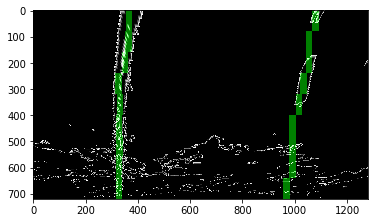

In [983]:
# Test Pipeline on single image

processor = VideoProc()
count = 0
#1046, 739, 989, 552, 943, 985-990, 998, 1004, 1036-037, 1044-1045

#Read image
img = cv2.imread("out_2_imgs/normal/frame_1045.jpg")
save_img(img, 'orig_img.jpg')

final_img = processor.process_image(img)

#Store the images to file
#print(count)
output_img_name = './out_2_imgs/11_img_frame_'+str(count)+'.jpg'
cv2.imwrite(output_img_name, final_img)


Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 391.5, 1015.5

Level: 1
Left argmax is : 28
right argmax conv is: 26
y_upper_limit: 560 , y_lower_limit: 640
left_min: 379, left_max: 429, left_center: 394.5
right_min: 1003, right_max: 1053, right_center: 1016.5

Level: 2
Left argmax is : 32
No values in right center
y_upper_limit: 480 , y_lower_limit: 560
left_min: 382, left_max: 432, left_center: 401.5
right_min: 1004, right_max: 1054, right_center: 1016.5

Level: 3
Left argmax is : 34
right argmax conv is: 46
y_upper_limit: 400 , y_lower_limit: 480
left_min: 389, left_max: 439, left_center: 410.5
right_min: 1004, right_max: 1054, right_center: 1037.5

Level: 4
Left argmax is : 36
right argmax conv is: 41
y_upper_limit: 320 , y_lower_limit: 400
left_min: 398, left_max: 448, left_center: 421.5
right_min: 1025, right_max: 1075, right_center: 1053.5

Level: 5
Left argmax is : 45
right argmax conv is: 34
y_upper_limit: 240 , y_lower_limit: 320
left_min: 409,

Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 407.5, 977.5

Level: 1
Left argmax is : 24
right argmax conv is: 22
y_upper_limit: 560 , y_lower_limit: 640
left_min: 395, left_max: 445, left_center: 406.5
right_min: 965, right_max: 1015, right_center: 974.5

Level: 2
Left argmax is : 19
right argmax conv is: 19
y_upper_limit: 480 , y_lower_limit: 560
left_min: 394, left_max: 444, left_center: 400.5
right_min: 962, right_max: 1012, right_center: 968.5

Level: 3
Left argmax is : 19
right argmax conv is: 49
y_upper_limit: 400 , y_lower_limit: 480
left_min: 388, left_max: 438, left_center: 394.5
right_min: 956, right_max: 1006, right_center: 992.5

Level: 4
Left argmax is : 17
right argmax conv is: 36
y_upper_limit: 320 , y_lower_limit: 400
left_min: 382, left_max: 432, left_center: 386.5
right_min: 980, right_max: 1030, right_center: 1003.5

Level: 5
Left argmax is : 16
right argmax conv is: 28
y_upper_limit: 240 , y_lower_limit: 320
left_min: 374, left_max

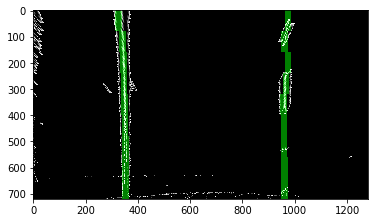

In [884]:

# Test pipeline on test images
#in_images = glob.glob('out_2_imgs/normal/frame_*.jpg')
#in_images = ['out_2_imgs/normal/frame_989.jpg']
#1046, 739, 989

processor = VideoProc()

# Apply threshold pipeline to test images
for count, img_path in enumerate(test_images):

    #Read image
    img = cv2.imread(img_path)
    #save_img(img, 'orig_img.jpg')

    final_img = processor.process_image(img)

    #Store the images to file
    #print(count)
    output_img_name = './out_2_imgs/img_frame_'+str(count)+'.jpg'
    cv2.imwrite(output_img_name, final_img)


0
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 404.5, 1022.5
1
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 405.5, 1023.5
2
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 405.5, 1024.5
3
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 407.5, 1024.5
4
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 408.5, 1024.5
5
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 409.5, 1010.5
6
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 409.5, 1014.5
7
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 408.5, 1021.5
8
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 409.5, 1018.5
9
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 406.5, 1023.5
10
Limits
X Left: (128, 576)
X Right: (7

Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 370.5, 982.5
86
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 370.5, 984.5
87
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 373.5, 983.5
88
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 372.5, 987.5
89
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 373.5, 989.5
90
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 375.5, 989.5
91
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 376.5, 990.5
92
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 375.5, 990.5
93
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 375.5, 981.5
94
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 376.5, 981.5
95
Limits
X Left: (128, 576)
X Right: (768,

Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 384.5, 988.5
171
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 384.5, 987.5
172
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 384.5, 998.5
173
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 382.5, 987.5
174
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 380.5, 992.5
175
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 381.5, 996.5
176
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 382.5, 1000.5
177
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 381.5, 1004.5
178
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 380.5, 1005.5
179
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 379.5, 1007.5
180
Limits
X Left: (128, 576)


Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 357.5, 969.5
256
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 357.5, 973.5
257
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 359.5, 975.5
258
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 359.5, 968.5
259
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 360.5, 970.5
260
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 360.5, 973.5
261
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 360.5, 976.5
262
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 360.5, 978.5
263
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 358.5, 982.5
264
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 359.5, 983.5
265
Limits
X Left: (128, 576)
X Ri

Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 393.5, 1003.5
341
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 392.5, 1005.5
342
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 392.5, 998.5
343
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 391.5, 1003.5
344
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 393.5, 1003.5
345
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 392.5, 1005.5
346
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 393.5, 1005.5
347
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 392.5, 1007.5
348
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 391.5, 1007.5
349
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 391.5, 1007.5
350
Limits
X Left: (128, 

Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 365.5, 980.5
425
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 364.5, 980.5
426
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 364.5, 974.5
427
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 364.5, 975.5
428
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 362.5, 978.5
429
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 362.5, 978.5
430
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 359.5, 979.5
431
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 360.5, 979.5
432
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 359.5, 978.5
433
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 359.5, 978.5
434
Limits
X Left: (128, 576)
X Ri

Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 357.5, 988.5
510
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 359.5, 984.5
511
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 358.5, 985.5
512
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 359.5, 985.5
513
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 359.5, 986.5
514
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 358.5, 987.5
515
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 358.5, 985.5
516
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 358.5, 986.5
517
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 359.5, 985.5
518
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 360.5, 988.5
519
Limits
X Left: (128, 576)
X Ri

Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 350.5, 995.5
595
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 349.5, 994.5
596
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 348.5, 993.5
597
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 347.5, 993.5
598
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 343.5, 1001.5
599
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 342.5, 1003.5
600
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 340.5, 1002.5
601
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 339.5, 1001.5
602
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 340.5, 1001.5
603
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 340.5, 993.5
604
Limits
X Left: (128, 576)

Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 391.5, 998.5
680
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 392.5, 998.5
681
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 391.5, 1005.5
682
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 392.5, 1004.5
683
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 394.5, 1001.5
684
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 394.5, 1000.5
685
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 393.5, 1000.5
686
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 392.5, 1001.5
687
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 392.5, 1000.5
688
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 393.5, 999.5
689
Limits
X Left: (128, 57

763
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 432.5, 1036.5
764
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 433.5, 1034.5
765
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 433.5, 1033.5
766
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 435.5, 1040.5
767
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 436.5, 1040.5
768
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 436.5, 1042.5
769
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 434.5, 1044.5
770
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 433.5, 1041.5
771
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 433.5, 1041.5
772
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 432.5, 1040.5
773
Limits
X Left: (

Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 363.5, 988.5
848
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 363.5, 997.5
849
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 362.5, 1000.5
850
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 361.5, 997.5
851
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 361.5, 998.5
852
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 360.5, 996.5
853
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 361.5, 994.5
854
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 361.5, 993.5
855
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 361.5, 991.5
856
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 361.5, 1000.5
857
Limits
X Left: (128, 576)
X 

Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 369.5, 1003.5
933
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 372.5, 1001.5
934
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 372.5, 1000.5
935
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 374.5, 998.5
936
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 374.5, 997.5
937
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 375.5, 995.5
938
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 375.5, 1001.5
939
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 374.5, 1001.5
940
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 375.5, 996.5
941
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 373.5, 996.5
942
Limits
X Left: (128, 576)

Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 358.5, 989.5
1017
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 355.5, 1000.5
1018
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 340.5, 994.5
1019
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 338.5, 995.5
1020
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 334.5, 993.5
1021
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 332.5, 993.5
1022
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 331.5, 993.5
1023
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 338.5, 987.5
1024
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 343.5, 998.5
1025
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 345.5, 993.5
1026
Limits
X Left: (128

Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 395.5, 1016.5
1101
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 396.5, 1017.5
1102
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 398.5, 1017.5
1103
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 401.5, 1015.5
1104
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 400.5, 1028.5
1105
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 402.5, 1023.5
1106
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 402.5, 1023.5
1107
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 402.5, 1020.5
1108
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 403.5, 1029.5
1109
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 400.5, 1028.5
1110
Limits
X L

Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 400.5, 1026.5
1184
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 401.5, 1023.5
1185
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 402.5, 1021.5
1186
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 401.5, 1016.5
1187
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 402.5, 1027.5
1188
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 403.5, 1025.5
1189
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 404.5, 1021.5
1190
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 406.5, 1017.5
1191
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 405.5, 1017.5
1192
Limits
X Left: (128, 576)
X Right: (768, 1152)
X Mid: 640, y upper: 540
Center: 406.5, 1014.5
1193
Limits
X L

error: /Users/jenkins/miniconda/1/x64/conda-bld/conda_1486587097465/work/opencv-3.1.0/modules/imgproc/src/undistort.cpp:191: error: (-215) dst.data != src.data in function undistort


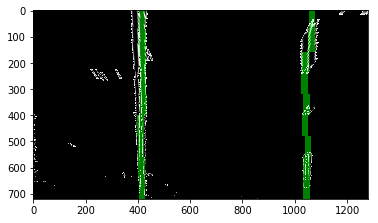

In [715]:
# Get the frames from video

import cv2
vidcap = cv2.VideoCapture('project_video.mp4')
success, image = vidcap.read()
count = 0
processor1 = VideoProc()
while success == True:
    success, image = vidcap.read()
    #if (count%100) == 0:
    print(count)
    cv2.imwrite("out_2_imgs/normal/frame_%d.jpg" % count, image)     # save frame as JPEG file
    final_img = processor.process_image(image)
    output_img_name = './out_2_imgs/lane/img_frame_'+str(count)+'.jpg'
    cv2.imwrite(output_img_name, final_img)
    count += 1

## Test Pipeline on Video

In [985]:
new_vid_processor = VideoProc()


output = 'project_video_output.mp4'
clip = VideoFileClip("project_video.mp4")

white_clip = clip.fl_image(new_vid_processor.process_image)
white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



100%|█████████▉| 1260/1261 [02:56<00:00,  7.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



## Test Pipeline on Challenge Video

In [87]:
output = 'project_challenge_video_output.mp4'
clip = VideoFileClip("challenge_video.mp4")

white_clip = clip.fl_image(process_image)
white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_challenge_video_output.mp4
[MoviePy] Writing video project_challenge_video_output.mp4


100%|██████████| 485/485 [00:53<00:00,  9.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_challenge_video_output.mp4 



In [85]:
'''









'''

'\n\n\n\n\n\n\n\n\n\n'

# Old Implementation Below - Not in Use

In [712]:
'''
###########################################################
###########################################################
###########################################################
###########################################################
#            OLD IMPLEMENTATION
###########################################################
###########################################################
###########################################################
###########################################################
'''
print()

## Finding the lines

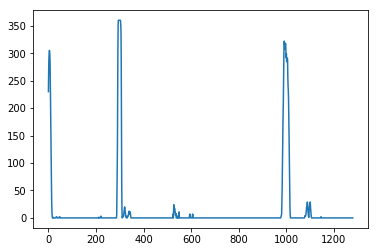

In [122]:
# Create a histogram from thresholded warped image

def get_histogram(img):
    # Histogram for all columns of half of image

    histogram = np.sum(img[(img.shape[0]//2):,:], axis=0)
    
    return histogram

histogram_curve_img = get_histogram(warped_curve_2_img)
plt.plot(histogram_curve_img)


#plt.imsave(out_dir+'curved_thresholded_warped_histogram_img.jpg', histogram_curve_img)
#save_img(histogram_curve_img, 'curved_thresholded_warped_histogram_img.jpg')

## Sliding window to find lane lines

In [189]:
def fit_lane_lines_from_warped(img):

    histogram = get_histogram(img)
    
    # create an output image to work on
    out_image = np.dstack((img, img, img))*255

    # Find the peak in the left and right part of historgram
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Number of sliding windows
    nwindows = 9

    # Get the height of each window
    window_height = np.int(img.shape[0]/nwindows)
    
    # Get all positions of (x, y) points with non-zero pixel values
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current pixels to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Width of the window +/- margin
    margin = 100 #pixels
    
    # Minimum number of pixels required to recenter window
    minpix = 50
    
    #Empty lists to receive left and right lane pixel index
    left_index = []
    right_index = []
    
    
    # Step through each window
    for window in range(nwindows):
        
        # Identify window boundaries in left and right lane
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - (window)*window_height
        
        winx_x_left_lane_left = leftx_current - margin
        winx_x_left_lane_right = leftx_current + margin
        winx_x_right_lane_left = rightx_current - margin
        winx_x_right_lane_right = rightx_current + margin
        
        # Draw the windows on the image
        # Left lane window
        # ----------- Vis image----------(left low point)--------------(right up point)---------------------color----size--
        cv2.rectangle(out_image, (winx_x_left_lane_left, win_y_low), (winx_x_left_lane_right, win_y_high), (0, 255, 0), 3)
        
        # Right lane window
        cv2.rectangle(out_image, (winx_x_right_lane_left, win_y_low), (winx_x_right_lane_right, win_y_high), (0, 255, 0), 3)
        

        #Identify non-zero pixels in these windows
        good_left_index = ( (nonzeroy >=  win_y_low) 
                           & (nonzeroy <  win_y_high) 
                           & (nonzerox >= winx_x_left_lane_left) 
                           & (nonzerox < winx_x_left_lane_right) ).nonzero()[0]
        
        good_right_index = ( (nonzeroy >=  win_y_low) 
                           & (nonzeroy <  win_y_high) 
                           & (nonzerox >= winx_x_right_lane_left) 
                           & (nonzerox < winx_x_right_lane_right) ).nonzero()[0]
        
        # Add these indices to list
        left_index.append(good_left_index)
        right_index.append(good_right_index)
        
        # If no of pixels in the above window were greater that min pixels, recenter next window to mean pos
        if len(good_left_index) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_index]))
            
        if len(good_right_index) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_index]))
    
    
    # Concatenate the arrays of indices
    left_index = np.concatenate(left_index)
    right_index = np.concatenate(right_index)
    
    #Extract left and right lane pixels
    leftx = nonzerox[left_index]
    lefty = nonzeroy[left_index]
    
    rightx = nonzerox[right_index]
    righty = nonzeroy[right_index]
    
    
    # Fit a second order polynomial through left and right points
    left_poly = np.polyfit(lefty, leftx, 2)
    right_poly = np.polyfit(righty, rightx, 2)
    
    
    # Draw the polynomials generated on image
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    
    #Equation of second order polynomial
    left_poly_x = left_poly[0]*ploty**2 + left_poly[1]*ploty + left_poly[2]
    right_poly_x = right_poly[0]*ploty**2 + right_poly[1]*ploty + right_poly[2]
    
    '''
    # Color the left and right image points to red and blue respectively
    out_image[lefty, leftx] = [255, 0, 0]
    out_image[righty, rightx] = [0, 0, 255]
    
    # Finally draw the image
    plt.imshow(out_image)
    
    # Draw the polynomial lines as well
    plt.plot(left_poly_x, ploty, color='yellow')
    plt.plot(right_poly_x, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    '''
    
    return ploty, left_poly, right_poly, left_poly_x, right_poly_x

In [190]:
ploty, left_poly, right_poly, left_poly_x, right_poly_x = fit_lane_lines_from_warped(warped_curve_2_img)

## Skip Sliding Window - Do local search for lane lines

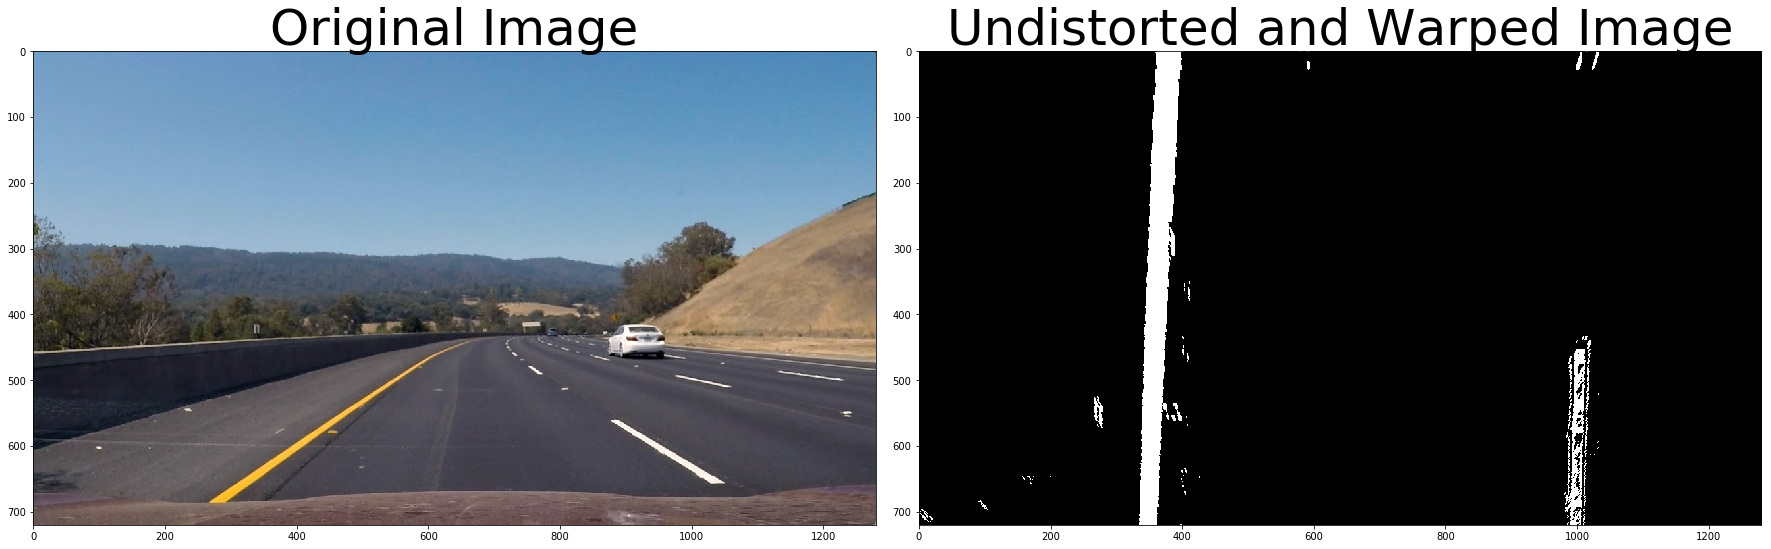

In [127]:
# Read another test image
test3_image = mpimg.imread(test_img_dir + 'test3.jpg')

# Undistort it
test3_img_undistort = undistort_img(test3_image, mtx, dist)

# Apply threshold
test3_img_threshold = pipeline(test3_img_undistort)

# Warp (perspective transform and apply thresholding)
test3_img_warped, Minv = warp_image(test3_img_threshold)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(test3_image)
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(test3_img_warped, cmap='gray')
ax2.set_title('Undistorted and Warped Image', fontsize=50)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


In [128]:
# Use local area search to detect lane line pixels

def find_lane_lines_using_local_search(img, left_poly, right_poly):
    
    nonzero = img.nonzero()
    nonzerox = np.array(nonzero[1])
    nonzeroy = np.array(nonzero[0])
    
    margin = 100
    
    left_index = ( 
        (nonzerox > (left_poly[0]*(nonzeroy**2) + left_poly[1]*nonzeroy + left_poly[2] - margin) ) 
        & (nonzerox < (left_poly[0]*(nonzeroy**2) + left_poly[1]*nonzeroy + left_poly[2] + margin) ) )
    
    right_index = ( 
        (nonzerox > (right_poly[0]*(nonzeroy**2) + right_poly[1]*nonzeroy + right_poly[2] - margin) ) 
        & (nonzerox < (right_poly[0]*(nonzeroy**2) + right_poly[1]*nonzeroy + right_poly[2] + margin) ) )
    
    leftx = nonzerox[left_index]
    lefty = nonzeroy[left_index]
    
    rightx = nonzerox[right_index]
    righty = nonzeroy[right_index]
    
    # Fit a second order polynomial
    left_poly = np.polyfit(lefty, leftx, 2)
    right_poly = np.polyfit(righty, rightx, 2)
    
    # Generate x & y values for plotting
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0])
    
    #Equation of second order polynomial
    left_poly_x = left_poly[0]*ploty**2 + left_poly[1]*ploty + left_poly[2]
    right_poly_x = right_poly[0]*ploty**2 + right_poly[1]*ploty + right_poly[2]
    
    
    # create an output image to work on
    out_img = np.dstack((img, img, img))*255
    window_img = np.zeros_like(out_img)
    
    
    # Color the left and right image points to red and blue respectively
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]
    
    
    # Generate a polygon to illustrate search area
    left_line_window1 = np.array( [np.transpose(np.vstack([left_poly_x-margin, ploty]))] )
    left_line_window2 = np.array( [np.flipud(np.transpose(np.vstack([left_poly_x+margin, ploty])))] )
    
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    
    right_line_window1 = np.array( [np.transpose(np.vstack([right_poly_x-margin, ploty]))] )
    right_line_window2 = np.array( [np.flipud(np.transpose(np.vstack([right_poly_x+margin, ploty])))] )
    
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    '''
    # Draw the lane lines box onto warped image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255,0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255,0))
    
    # Stack out_img with window_img
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    plt.imshow(result)
    plt.plot(left_poly_x, ploty, color='yellow')
    plt.plot(right_poly_x, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    '''
    
    return ploty, left_poly, right_poly, leftx, lefty, rightx, righty, left_poly_x, right_poly_x

In [130]:
# Apply localized line search onto test3.jpg warped, thresholed, undistorted image
ploty, left_poly, right_poly, leftx, lefty, rightx, righty, left_poly_x, right_poly_x = find_lane_lines_using_local_search(test3_img_warped, left_poly, right_poly)